In [1]:
import numpy as np
import pandas as pd
import pytiff
import h5py
import time
import os

from tqdm.auto import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
!ls /mnt/linux-data/codex/preprocessed_data/201021_BreastFFPE_Final/

201021_BreastFFPE_Final_1_tissue.tif	201021_BreastFFPE_Final_3_cells.csv
201021_BreastFFPE_Final_2_nuclei.tif	CODEXobj_201021_BreastFFPE_Final.mat
201021_BreastFFPE_Final_2_stardist.tif	images


In [3]:
cells = pd.read_csv('/mnt/linux-data/codex/preprocessed_data/201021_BreastFFPE_Final/201021_BreastFFPE_Final_3_cells.csv', 
                    index_col=0, header=0)
cells.head(10)

,X,Y,Size
cell_ID,,,
cell_1,14,1779,410
cell_2,11,1799,329
cell_3,5,1827,138
cell_4,4,1918,86
cell_5,5,1960,122
cell_6,8,2655,229
cell_7,13,2671,473
cell_8,6,2729,162
cell_9,8,2806,233


In [4]:
imagefs = !ls /mnt/linux-data/codex/preprocessed_data/201021_BreastFFPE_Final/images/*.tif
dapi_images = [f for f in imagefs if 'DAPI' in f]
non_dapi_images = [f for f in imagefs if 'DAPI' not in f]
non_dapi_images = [f for f in non_dapi_images if 'Blank' not in f]
non_dapi_images = [f for f in non_dapi_images if 'Empty' not in f]
for f in non_dapi_images:
    print(os.path.basename(f))

201021_BreastFFPE_Final_10_OX40L_10.tif
201021_BreastFFPE_Final_11_CD45_11.tif
201021_BreastFFPE_Final_12_CD20_12.tif
201021_BreastFFPE_Final_14_CD134_14.tif
201021_BreastFFPE_Final_15_CD68_15.tif
201021_BreastFFPE_Final_16_CD31_16.tif
201021_BreastFFPE_Final_18_CD103_18.tif
201021_BreastFFPE_Final_19_HLA-DR_19.tif
201021_BreastFFPE_Final_20_CXCR5_20.tif
201021_BreastFFPE_Final_22_IgG_22.tif
201021_BreastFFPE_Final_23_CD3e_23.tif
201021_BreastFFPE_Final_24_Ki-67_24.tif
201021_BreastFFPE_Final_26_LAG3_26.tif
201021_BreastFFPE_Final_27_CXCL13_27.tif
201021_BreastFFPE_Final_28_IgA_28.tif
201021_BreastFFPE_Final_30_CD89_30.tif
201021_BreastFFPE_Final_31_PNaD_31.tif
201021_BreastFFPE_Final_32_PD-L1_32.tif
201021_BreastFFPE_Final_34_PD-1_34.tif
201021_BreastFFPE_Final_35_CD11c_35.tif
201021_BreastFFPE_Final_36_CD80_36.tif
201021_BreastFFPE_Final_38_CD69_38.tif
201021_BreastFFPE_Final_39_TIM3_39.tif
201021_BreastFFPE_Final_40_CD45RO_40.tif
201021_BreastFFPE_Final_42_CD40LG_42.tif
201021_Breas

In [5]:
EXPT_NAME = '201021_BreastFFPE_Final'
channel_names = [os.path.basename(x) for x in non_dapi_images]
# channel_names = [x.replace(f'{EXPT_NAME}_','') for x in channel_names]
channel_names = [x.replace(f'.tif','') for x in channel_names]
channel_names = [x.split('_')[-2] for x in channel_names]
# channel_names = [x.replace('-', '_') for x in channel_names]
channel_names = ["DAPI"] + channel_names
print( channel_names )

['DAPI', 'OX40L', 'CD45', 'CD20', 'CD134', 'CD68', 'CD31', 'CD103', 'HLA-DR', 'CXCR5', 'IgG', 'CD3e', 'Ki-67', 'LAG3', 'CXCL13', 'IgA', 'CD89', 'PNaD', 'PD-L1', 'PD-1', 'CD11c', 'CD80', 'CD69', 'TIM3', 'CD45RO', 'CD40LG', 'FOXP3', 'CD64', 'GZMB', 'C1q', 'CD40', 'CD45RA', 'CD138', 'IL7R', 'IgM', 'PDGFRb', 'aSMA', 'CD8', 'CD4', 'PanCytoK']


In [6]:
image_paths = [dapi_images[0]] + non_dapi_images
print(len(image_paths))
# image_handles = [pytiff.Tiff(dapi_images[0])] + [pytiff.Tiff(f) for f in non_dapi_images]

40


array([  69.,  156.,  697., 1168.])

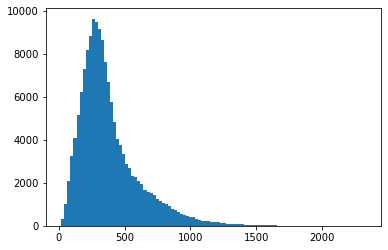

In [7]:
_ = plt.hist(cells.Size, bins=100)
np.quantile(cells.Size, [0.01, 0.1, 0.9, 0.99])

In [8]:
size = 64

def pull_nuclei(coords, image_paths, out_file='dataset.hdf5', size=64, min_area=100, channel_names=None):
    h0 = pytiff.Tiff(image_paths[0])
    sizeh = int(size/2)
    h, w = h0.shape
    print(h, w)
    maxh = h - sizeh
    maxw = w - sizeh
    h0.close()
    
    if channel_names is None:
        channel_names = [f'ch{i:02d}' for i in range(len(image_paths))]
    assert len(channel_names) == len(image_paths)
    
    h5f = h5py.File(out_file, "w")
    
    datasets = []
    for c in channel_names:
        d = h5f.create_dataset(f'cells/{c}', shape=(coords.shape[0],size,size), maxshape=(None,size,size),
                               dtype='i', chunks=(1,size,size), compression='gzip')
        datasets.append(d)
        
    # remove coords too near the edges:
    # remember, x = "width" = size[1]; y = "height" = size[0]
    coords = coords.query("X > @sizeh & X < @maxw & Y > @sizeh & Y < @maxh")
    if min_area is not None:
        coords = coords.query("Size > @min_area")
    
    print(f'Pulling {coords.shape[0]} cells')
    for pth, d, c in zip(image_paths, datasets, channel_names):
        print(f'Pulling from channel {c}')
        h = pytiff.Tiff(pth)
        page = h.pages[0][:]
        
        i = 0
        for x, y in tqdm(zip(coords.X, coords.Y)):
            # print(x, y, a)
            bbox = [y-sizeh, y+sizeh, x-sizeh, x+sizeh]
            img = (255 * (page[bbox[0]:bbox[1], bbox[2]:bbox[3]] / 2**16)).astype(np.uint8)
            # img = [255 * (h.pages[0][bbox[0]:bbox[1], bbox[2]:bbox[3]] / 2**16).astype(np.uint8) for h in image_handles]
            # print(np.mean(img))
            # xout[i, :, :, :] = np.dstack(img)
            d[i,...] = img

            i += 1
            # if i > 5000: 
            #     break
        h.close()
        h5f.flush()
    h5f.close()

pull_nuclei(cells, image_paths, out_file='dataset.hdf5', min_area=100, channel_names=channel_names)

7602 16830
Pulling 146791 cells
Pulling from channel DAPI



Pulling from channel OX40L



Pulling from channel CD45



Pulling from channel CD20



Pulling from channel CD134



Pulling from channel CD68



Pulling from channel CD31



Pulling from channel CD103



Pulling from channel HLA-DR



Pulling from channel CXCR5



Pulling from channel IgG


KeyboardInterrupt: 